In [1]:
import torch

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

In [3]:
# 如果没有文件夹就创建一个文件夹
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

### 超参数设置

In [4]:
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 200
batch_size = 100
learning_rate = 1e-3

### 数据集读取

In [5]:
dataset = torchvision.datasets.MNIST(root='../../../data/minist',
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# 数据加载器
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

### 模型建立

In [6]:
# VAE model
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim) # 均值 向量
        self.fc3 = nn.Linear(h_dim, z_dim) # 保准方差 向量
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    # 编码过程
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    # 随机生成隐含向量
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    # 解码过程
    def decode(self, z):
        h = F.relu(self.fc4(z))
        return F.sigmoid(self.fc5(h))
    
    # 整个前向传播过程：编码-》解码
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

### 初始化

In [7]:
# 实例化一个模型
model = VAE()
# 创建优化器
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### 模型训练

In [8]:
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # 获取样本，并前向传播

        x = x.view(-1, image_size)
        x_reconst, mu, log_var = model(x)
        
        # 计算重构损失和KL散度（KL散度用于衡量两种分布的相似程度）
        # KL散度的计算可以参考论文或者文章开头的链接
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # 反向传播和优化
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(), kl_div.item()))
    
    # 利用训练的模型进行测试
    with torch.no_grad():
        # 随机生成的图像
        z = torch.randn(batch_size, z_dim)
        out = model.decode(z).view(-1, 1, 28, 28)
        save_image(out, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))

        # 重构的图像
        out, _, _ = model(x)
        x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
        save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))

/usr/local/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/200], Step [100/600], Reconst Loss: 18314.1191, KL Div: 891.8773
Epoch[1/200], Step [200/600], Reconst Loss: 14507.3311, KL Div: 1539.8718
Epoch[1/200], Step [300/600], Reconst Loss: 12809.0771, KL Div: 1839.1624
Epoch[1/200], Step [400/600], Reconst Loss: 11397.8164, KL Div: 1933.8129
Epoch[1/200], Step [500/600], Reconst Loss: 11269.6328, KL Div: 2094.2686
Epoch[1/200], Step [600/600], Reconst Loss: 10184.7881, KL Div: 2090.3914
Epoch[2/200], Step [100/600], Reconst Loss: 10021.4111, KL Div: 2284.3860
Epoch[2/200], Step [200/600], Reconst Loss: 9412.1035, KL Div: 2228.7485
Epoch[2/200], Step [300/600], Reconst Loss: 9613.1758, KL Div: 2336.7700
Epoch[2/200], Step [400/600], Reconst Loss: 9381.0879, KL Div: 2332.4807
Epoch[2/200], Step [500/600], Reconst Loss: 8863.8799, KL Div: 2370.5066
Epoch[2/200], Step [600/600], Reconst Loss: 9014.7373, KL Div: 2428.0793
Epoch[3/200], Step [100/600], Reconst Loss: 8994.8125, KL Div: 2386.9683
Epoch[3/200], Step [200/600], Reconst Loss: 8

Epoch[19/200], Step [500/600], Reconst Loss: 7847.1045, KL Div: 2554.9912
Epoch[19/200], Step [600/600], Reconst Loss: 8105.3047, KL Div: 2610.9338
Epoch[20/200], Step [100/600], Reconst Loss: 7945.6509, KL Div: 2550.7939
Epoch[20/200], Step [200/600], Reconst Loss: 7349.4746, KL Div: 2478.2651
Epoch[20/200], Step [300/600], Reconst Loss: 7881.3232, KL Div: 2559.9631
Epoch[20/200], Step [400/600], Reconst Loss: 7537.9492, KL Div: 2460.8389
Epoch[20/200], Step [500/600], Reconst Loss: 7829.4312, KL Div: 2432.5376
Epoch[20/200], Step [600/600], Reconst Loss: 8374.9443, KL Div: 2560.2102
Epoch[21/200], Step [100/600], Reconst Loss: 7724.3667, KL Div: 2529.8752
Epoch[21/200], Step [200/600], Reconst Loss: 7942.2383, KL Div: 2646.0090
Epoch[21/200], Step [300/600], Reconst Loss: 7708.7603, KL Div: 2475.0618
Epoch[21/200], Step [400/600], Reconst Loss: 7739.5303, KL Div: 2594.4956
Epoch[21/200], Step [500/600], Reconst Loss: 7983.8257, KL Div: 2589.5081
Epoch[21/200], Step [600/600], Reconst

Epoch[38/200], Step [200/600], Reconst Loss: 7843.3374, KL Div: 2536.9014
Epoch[38/200], Step [300/600], Reconst Loss: 7779.8643, KL Div: 2535.8733
Epoch[38/200], Step [400/600], Reconst Loss: 7820.9980, KL Div: 2544.9187
Epoch[38/200], Step [500/600], Reconst Loss: 7637.7983, KL Div: 2527.0352
Epoch[38/200], Step [600/600], Reconst Loss: 7969.2910, KL Div: 2525.5818
Epoch[39/200], Step [100/600], Reconst Loss: 7709.3301, KL Div: 2553.4961
Epoch[39/200], Step [200/600], Reconst Loss: 7372.3066, KL Div: 2541.1379
Epoch[39/200], Step [300/600], Reconst Loss: 7593.1177, KL Div: 2608.5962
Epoch[39/200], Step [400/600], Reconst Loss: 7561.7783, KL Div: 2569.0581
Epoch[39/200], Step [500/600], Reconst Loss: 7489.5220, KL Div: 2357.9304
Epoch[39/200], Step [600/600], Reconst Loss: 7601.3154, KL Div: 2567.7161
Epoch[40/200], Step [100/600], Reconst Loss: 7922.0044, KL Div: 2594.4595
Epoch[40/200], Step [200/600], Reconst Loss: 7488.5483, KL Div: 2460.1106
Epoch[40/200], Step [300/600], Reconst

Epoch[56/200], Step [500/600], Reconst Loss: 7675.1909, KL Div: 2484.8955
Epoch[56/200], Step [600/600], Reconst Loss: 7723.1045, KL Div: 2520.3394
Epoch[57/200], Step [100/600], Reconst Loss: 7276.6372, KL Div: 2442.1758
Epoch[57/200], Step [200/600], Reconst Loss: 7152.9321, KL Div: 2452.5796
Epoch[57/200], Step [300/600], Reconst Loss: 7824.9116, KL Div: 2526.0239
Epoch[57/200], Step [400/600], Reconst Loss: 8093.3975, KL Div: 2521.9546
Epoch[57/200], Step [500/600], Reconst Loss: 7952.3145, KL Div: 2568.8840
Epoch[57/200], Step [600/600], Reconst Loss: 7247.5635, KL Div: 2530.0083
Epoch[58/200], Step [100/600], Reconst Loss: 7702.6777, KL Div: 2470.9087
Epoch[58/200], Step [200/600], Reconst Loss: 7537.2837, KL Div: 2494.7344
Epoch[58/200], Step [300/600], Reconst Loss: 7617.1602, KL Div: 2490.9683
Epoch[58/200], Step [400/600], Reconst Loss: 7630.8242, KL Div: 2611.3967
Epoch[58/200], Step [500/600], Reconst Loss: 7545.1411, KL Div: 2531.2078
Epoch[58/200], Step [600/600], Reconst

Epoch[75/200], Step [200/600], Reconst Loss: 7303.8062, KL Div: 2463.6619
Epoch[75/200], Step [300/600], Reconst Loss: 7751.9326, KL Div: 2518.2725
Epoch[75/200], Step [400/600], Reconst Loss: 7636.6445, KL Div: 2591.3340
Epoch[75/200], Step [500/600], Reconst Loss: 7419.4614, KL Div: 2491.1711
Epoch[75/200], Step [600/600], Reconst Loss: 7482.8633, KL Div: 2466.3511
Epoch[76/200], Step [100/600], Reconst Loss: 7475.8525, KL Div: 2504.8167
Epoch[76/200], Step [200/600], Reconst Loss: 7067.9863, KL Div: 2533.6936
Epoch[76/200], Step [300/600], Reconst Loss: 7672.2891, KL Div: 2557.0017
Epoch[76/200], Step [400/600], Reconst Loss: 7705.5322, KL Div: 2541.6594
Epoch[76/200], Step [500/600], Reconst Loss: 7904.4009, KL Div: 2621.0256
Epoch[76/200], Step [600/600], Reconst Loss: 7512.9053, KL Div: 2467.5574
Epoch[77/200], Step [100/600], Reconst Loss: 7730.8408, KL Div: 2593.0281
Epoch[77/200], Step [200/600], Reconst Loss: 7493.5239, KL Div: 2470.9580
Epoch[77/200], Step [300/600], Reconst

Epoch[93/200], Step [500/600], Reconst Loss: 7541.6367, KL Div: 2500.5525
Epoch[93/200], Step [600/600], Reconst Loss: 7575.7690, KL Div: 2509.9465
Epoch[94/200], Step [100/600], Reconst Loss: 7667.5527, KL Div: 2536.3354
Epoch[94/200], Step [200/600], Reconst Loss: 7623.6943, KL Div: 2512.6956
Epoch[94/200], Step [300/600], Reconst Loss: 7685.2271, KL Div: 2565.3315
Epoch[94/200], Step [400/600], Reconst Loss: 7233.8008, KL Div: 2347.0405
Epoch[94/200], Step [500/600], Reconst Loss: 7570.3765, KL Div: 2579.9192
Epoch[94/200], Step [600/600], Reconst Loss: 7687.0215, KL Div: 2506.7222
Epoch[95/200], Step [100/600], Reconst Loss: 7702.1284, KL Div: 2544.1775
Epoch[95/200], Step [200/600], Reconst Loss: 7702.6460, KL Div: 2544.0791
Epoch[95/200], Step [300/600], Reconst Loss: 7425.0405, KL Div: 2469.3647
Epoch[95/200], Step [400/600], Reconst Loss: 7931.5142, KL Div: 2586.0103
Epoch[95/200], Step [500/600], Reconst Loss: 7793.1553, KL Div: 2602.8564
Epoch[95/200], Step [600/600], Reconst

Epoch[112/200], Step [100/600], Reconst Loss: 7469.4614, KL Div: 2523.5515
Epoch[112/200], Step [200/600], Reconst Loss: 7604.6392, KL Div: 2576.6501
Epoch[112/200], Step [300/600], Reconst Loss: 7275.4688, KL Div: 2483.3701
Epoch[112/200], Step [400/600], Reconst Loss: 7818.5693, KL Div: 2554.7004
Epoch[112/200], Step [500/600], Reconst Loss: 7540.5273, KL Div: 2500.0186
Epoch[112/200], Step [600/600], Reconst Loss: 7623.4946, KL Div: 2522.6572
Epoch[113/200], Step [100/600], Reconst Loss: 7560.9883, KL Div: 2530.7834
Epoch[113/200], Step [200/600], Reconst Loss: 7528.5068, KL Div: 2472.9023
Epoch[113/200], Step [300/600], Reconst Loss: 7708.4722, KL Div: 2492.2847
Epoch[113/200], Step [400/600], Reconst Loss: 7548.2954, KL Div: 2493.3127
Epoch[113/200], Step [500/600], Reconst Loss: 7411.3857, KL Div: 2438.3906
Epoch[113/200], Step [600/600], Reconst Loss: 7448.4346, KL Div: 2512.6318
Epoch[114/200], Step [100/600], Reconst Loss: 7462.2739, KL Div: 2467.5623
Epoch[114/200], Step [200

Epoch[130/200], Step [300/600], Reconst Loss: 7442.1201, KL Div: 2456.5771
Epoch[130/200], Step [400/600], Reconst Loss: 7443.8994, KL Div: 2446.9146
Epoch[130/200], Step [500/600], Reconst Loss: 7871.0820, KL Div: 2587.4749
Epoch[130/200], Step [600/600], Reconst Loss: 7436.0708, KL Div: 2475.8804
Epoch[131/200], Step [100/600], Reconst Loss: 7233.1494, KL Div: 2394.9551
Epoch[131/200], Step [200/600], Reconst Loss: 7723.1987, KL Div: 2521.2451
Epoch[131/200], Step [300/600], Reconst Loss: 7350.3018, KL Div: 2495.5342
Epoch[131/200], Step [400/600], Reconst Loss: 7697.0137, KL Div: 2549.1938
Epoch[131/200], Step [500/600], Reconst Loss: 7309.6396, KL Div: 2431.0266
Epoch[131/200], Step [600/600], Reconst Loss: 7439.7754, KL Div: 2521.7180
Epoch[132/200], Step [100/600], Reconst Loss: 7377.6553, KL Div: 2452.8411
Epoch[132/200], Step [200/600], Reconst Loss: 7347.7207, KL Div: 2464.3967
Epoch[132/200], Step [300/600], Reconst Loss: 7747.1289, KL Div: 2524.0322
Epoch[132/200], Step [400

Epoch[148/200], Step [500/600], Reconst Loss: 7601.5869, KL Div: 2444.1475
Epoch[148/200], Step [600/600], Reconst Loss: 7522.3037, KL Div: 2432.0991
Epoch[149/200], Step [100/600], Reconst Loss: 7576.3145, KL Div: 2463.7415
Epoch[149/200], Step [200/600], Reconst Loss: 7474.2979, KL Div: 2481.4358
Epoch[149/200], Step [300/600], Reconst Loss: 7526.2446, KL Div: 2488.3889
Epoch[149/200], Step [400/600], Reconst Loss: 7299.9761, KL Div: 2434.6736
Epoch[149/200], Step [500/600], Reconst Loss: 7459.7339, KL Div: 2449.3005
Epoch[149/200], Step [600/600], Reconst Loss: 7526.4111, KL Div: 2535.9885
Epoch[150/200], Step [100/600], Reconst Loss: 7415.3872, KL Div: 2530.8992
Epoch[150/200], Step [200/600], Reconst Loss: 7667.2734, KL Div: 2562.0461
Epoch[150/200], Step [300/600], Reconst Loss: 7410.3623, KL Div: 2434.9229
Epoch[150/200], Step [400/600], Reconst Loss: 7675.3901, KL Div: 2526.0469
Epoch[150/200], Step [500/600], Reconst Loss: 7464.6626, KL Div: 2400.4072
Epoch[150/200], Step [600

Epoch[167/200], Step [100/600], Reconst Loss: 7453.1562, KL Div: 2467.7178
Epoch[167/200], Step [200/600], Reconst Loss: 7701.1943, KL Div: 2496.9746
Epoch[167/200], Step [300/600], Reconst Loss: 7607.8984, KL Div: 2473.8235
Epoch[167/200], Step [400/600], Reconst Loss: 7528.7241, KL Div: 2546.3889
Epoch[167/200], Step [500/600], Reconst Loss: 6966.0835, KL Div: 2436.9158
Epoch[167/200], Step [600/600], Reconst Loss: 7231.8149, KL Div: 2379.4373
Epoch[168/200], Step [100/600], Reconst Loss: 7713.4795, KL Div: 2533.2039
Epoch[168/200], Step [200/600], Reconst Loss: 7536.1758, KL Div: 2564.6636
Epoch[168/200], Step [300/600], Reconst Loss: 7257.6387, KL Div: 2392.6355
Epoch[168/200], Step [400/600], Reconst Loss: 7189.3813, KL Div: 2402.7300
Epoch[168/200], Step [500/600], Reconst Loss: 7591.5586, KL Div: 2483.6885
Epoch[168/200], Step [600/600], Reconst Loss: 7701.2236, KL Div: 2564.5969
Epoch[169/200], Step [100/600], Reconst Loss: 7800.6260, KL Div: 2598.1438
Epoch[169/200], Step [200

Epoch[185/200], Step [300/600], Reconst Loss: 7336.2495, KL Div: 2442.6431
Epoch[185/200], Step [400/600], Reconst Loss: 7664.2158, KL Div: 2468.5281
Epoch[185/200], Step [500/600], Reconst Loss: 7645.7227, KL Div: 2539.5955
Epoch[185/200], Step [600/600], Reconst Loss: 7473.0781, KL Div: 2466.8301
Epoch[186/200], Step [100/600], Reconst Loss: 7337.8774, KL Div: 2414.1670
Epoch[186/200], Step [200/600], Reconst Loss: 7410.7954, KL Div: 2554.0867
Epoch[186/200], Step [300/600], Reconst Loss: 7364.7603, KL Div: 2471.2888
Epoch[186/200], Step [400/600], Reconst Loss: 7345.8896, KL Div: 2446.5557
Epoch[186/200], Step [500/600], Reconst Loss: 7591.9204, KL Div: 2529.6257
Epoch[186/200], Step [600/600], Reconst Loss: 7335.3945, KL Div: 2443.4856
Epoch[187/200], Step [100/600], Reconst Loss: 7390.5146, KL Div: 2509.8630
Epoch[187/200], Step [200/600], Reconst Loss: 7667.6909, KL Div: 2509.3462
Epoch[187/200], Step [300/600], Reconst Loss: 7473.4038, KL Div: 2520.1497
Epoch[187/200], Step [400

### 结果可视化展示

In [12]:
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import numpy as np

### 随机生成的图片生成效果展示

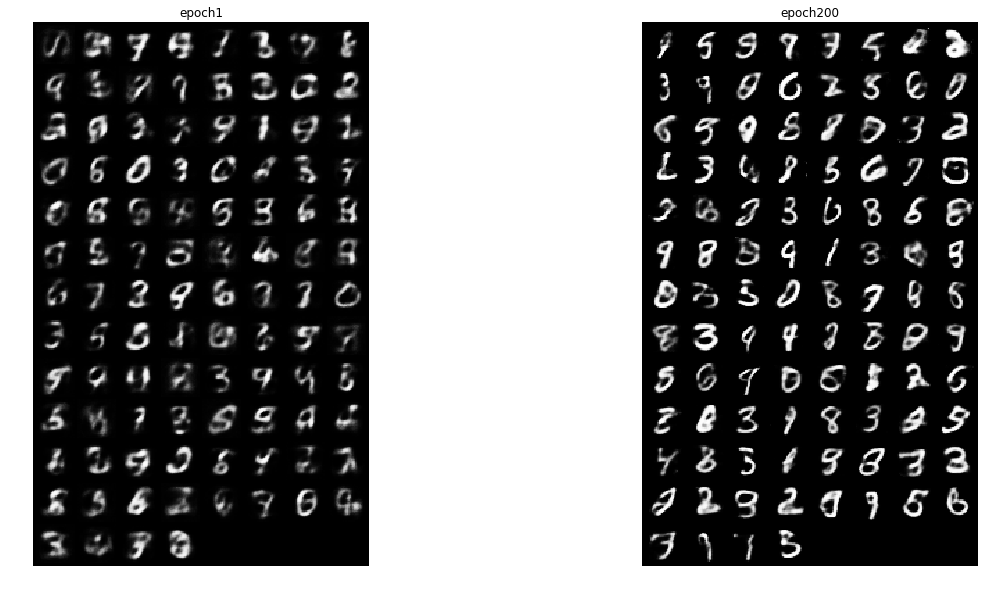

In [13]:
sampledPath1 = './samples/sampled-1.png'
sampledImage1 = mpimg.imread(sampledPath1)

sampledPath200 = './samples/sampled-200.png'
sampledImage200 = mpimg.imread(sampledPath200)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1 ) # 显示图片
plt.title("epoch1")
plt.imshow(sampledImage1) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.subplot(1,2,2 ) # 显示图片
plt.title("epoch200")
plt.imshow(sampledImage200) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

### 使用原始图像进行重构的样本效果展示

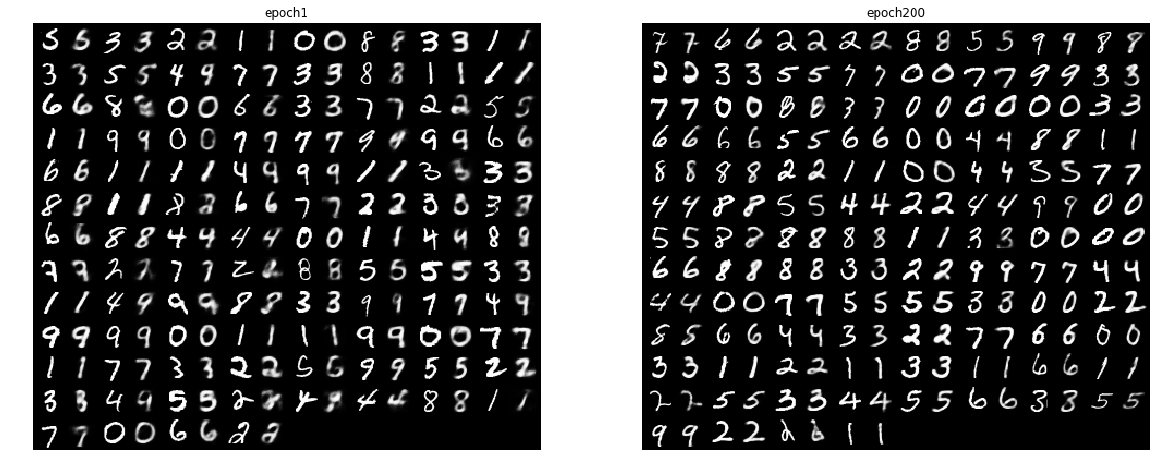

In [14]:
reconsPath1 = './samples/reconst-1.png'
reconsImage1 = mpimg.imread(reconsPath1)

reconsPath200 = './samples/reconst-200.png'
reconsImage200 = mpimg.imread(reconsPath200)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1 ) # 显示图片
plt.title("epoch1")
plt.imshow(reconsImage1) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.subplot(1,2,2 ) # 显示图片
plt.title("epoch200")
plt.imshow(reconsImage200) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

In [15]:
!pwd

/Users/yhk/program/jupyter-notebook/github/webshell_sample_generate
